In [2]:
from numpy.linalg import qr, svd

from scipy.linalg import subspace_angles

import math

import jax
import jax.numpy as jnp
from jax import grad, random, vmap
import optax

from kernel_sca_inducing_points import *
from utils import *
from kernels import *

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score

from NN_torch import *

In [31]:
def get_reg(X_train,y_train,X_test, y_test):
    regr = RidgeCV()
    reg = regr.fit(X_train, y_train)   
    return reg.score(X_test, y_test), reg.predict(X_test)   

def get_r2_results(behaviour, ds, split = 10, lag = 5): 
    y_train = behaviour[split:,:,lag:].swapaxes(1,2).reshape(-1, behaviour.shape[1])
    y_test = behaviour[:split,:,lag:].swapaxes(1,2).reshape(-1, behaviour.shape[1])

    ls_r2_ksca = []
    ls_su_ksca = []
    ls_r2_sca = []
    ls_su_sca = []
    ls_r2_pca = []
    ls_su_pca = []
    ls_traces_ksca = []
    ls_traces_sca = []
    ls_traces_pca = []
    ls_principal_angle_kSCA_SCA = []
    ls_principal_angle_kSCA_PCA = []
    ls_principal_angle_SCA_PCA = []
    for d in ds:
        Y_kSCA = np.load(f"/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/kernel_/neural_psth/projection_{d}d_gaussian.npy")
        #Y_kSCA = np.load(f"/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/neural_spikes/projection_{d}d_gaussian.npy")
        X_train = Y_kSCA[split:,:,:-lag].swapaxes(1,2).reshape(-1, d)
        X_test = Y_kSCA[:split,:,:-lag].swapaxes(1,2).reshape(-1, d)

        ls_r2_ksca.append( get_reg(X_train,y_train,X_test, y_test)[0] )
        ls_traces_ksca.append( get_reg(X_train,y_train,X_test, y_test)[1] )
        ls_su_ksca.append( compute_S_all_pairs(jnp.array(Y_kSCA)))

        Y_SCA = np.load(f"/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/kernel_/neural_psth/projection_{d}d_linear.npy")
        #Y_SCA = np.load(f"/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/neural_spikes/projection_{d}d_linear.npy")
        X_train = Y_SCA[split:,:,:-lag].swapaxes(1,2).reshape(-1, d)
        X_test = Y_SCA[:split,:,:-lag].swapaxes(1,2).reshape(-1, d)
        ls_r2_sca.append( get_reg(X_train,y_train,X_test, y_test)[0] )
        ls_traces_sca.append( get_reg(X_train,y_train,X_test, y_test)[1] )
        ls_su_sca.append( compute_S_all_pairs(jnp.array(Y_SCA)))

        Y_PCA = np.load(f"/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/pca_psth/Y_pca_{d}d.npy")
        #Y_PCA = np.load(f"/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/pca_spikes/Y_pca_{d}d_spikes.npy")
        X_train = Y_PCA[split:,:,:-lag].swapaxes(1,2).reshape(-1, d)
        X_test = Y_PCA[:split,:,:-lag].swapaxes(1,2).reshape(-1, d)
        ls_r2_pca.append( get_reg(X_train,y_train,X_test, y_test)[0] )
        ls_traces_pca.append( get_reg(X_train,y_train,X_test, y_test)[1] )
        ls_su_pca.append( compute_S_all_pairs(jnp.array(Y_PCA)))


        Q_Y_kSCA, _ = qr(Y_kSCA.swapaxes(1,2).reshape(-1,d))
        Q_Y_SCA, _ = qr(Y_SCA.swapaxes(1,2).reshape(-1,d))
        Q_Y_PCA, _ = qr(Y_PCA.swapaxes(1,2).reshape(-1,d))
        ls_principal_angle_kSCA_SCA.append( np.rad2deg(subspace_angles(Q_Y_kSCA, Q_Y_SCA))[-1] )
        ls_principal_angle_kSCA_PCA.append( np.rad2deg(subspace_angles(Q_Y_kSCA, Q_Y_PCA))[-1] )
        ls_principal_angle_SCA_PCA.append( np.rad2deg(subspace_angles(Q_Y_SCA, Q_Y_PCA))[-1] )


    X = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/psth.npy').swapaxes(1,2)
    #X = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/train_spksmth.npy').swapaxes(1,2)
    X_train = X[split:,:,:-lag].swapaxes(1,2).reshape(-1, X.shape[1])
    X_test = X[:split,:,:-lag].swapaxes(1,2).reshape(-1, X.shape[1])
    r2_X = get_reg(X_train,y_train,X_test, y_test)[0]
    return ls_r2_ksca, ls_r2_sca, ls_r2_pca, r2_X, ls_su_ksca, ls_su_sca, ls_su_pca, ls_principal_angle_kSCA_SCA, ls_principal_angle_kSCA_PCA, ls_principal_angle_SCA_PCA, ls_traces_ksca, ls_traces_sca, ls_traces_pca

def get_r2_plots(title, ls_r2_ksca, ls_r2_sca, ls_r2_pca, r2_X, ls_su_ksca, ls_su_sca, ls_su_pca, ds):
    fig, axs = plt.subplots(1,2, figsize=(10,3))
    axs[0].plot(ls_r2_ksca, label='kSCA')
    axs[0].plot(ls_r2_sca, label='kSCA')
    axs[0].plot(ls_r2_pca, label='PCA')
    axs[0].set_title(title)

    axs[0].axhline(r2_X, color='black', linestyle='--')
    axs[0].set_ylabel(r"$R^2$")

    axs[1].plot(ls_su_ksca, label='kSCA')
    axs[1].plot(ls_su_sca, label='SCA')
    axs[1].plot(ls_su_pca, label='PCA')
    axs[1].set_ylabel(r"$S[\phi(U)]$")

    data_length = len(ds) 
    tick_positions = np.linspace(0, data_length - 1, num=len(ds)) 
    tick_labels = ds
    for ax in axs:
        ax.set_xlabel(r"$d$")
        ax.set_xticks(tick_positions, tick_labels)
        ax.grid()
        ax.spines[['right', 'top']].set_visible(False)

    plt.legend()
    #plt.suptitle(title)



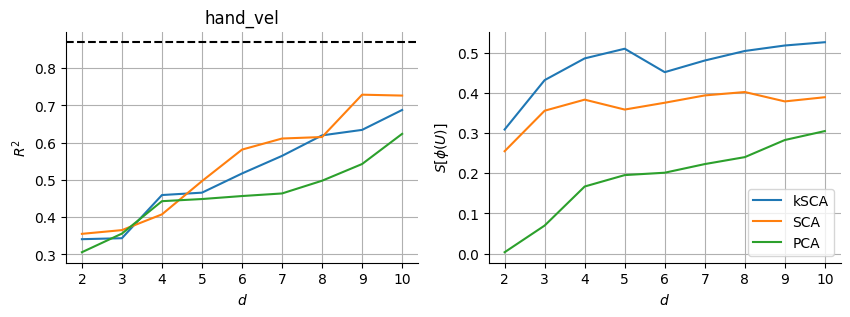

In [32]:
split = 10
lag = 5

ds = np.arange(2,11)
#ds = [2, 3, 6]
#path = '/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/train_behavior.npy' #.swapaxes(1,2)

path = '/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/behaviour/hand_vel.npy'
behaviour = np.load(path)
ls_r2_ksca, ls_r2_sca, ls_r2_pca, r2_X, ls_su_ksca, ls_su_sca, ls_su_pca, ls_principal_angle_kSCA_SCA, ls_principal_angle_kSCA_PCA, ls_principal_angle_SCA_PCA, ls_traces_ksca, ls_traces_sca, ls_traces_pca = get_r2_results(behaviour, ds)
get_r2_plots('hand_vel', ls_r2_ksca, ls_r2_sca, ls_r2_pca, r2_X, ls_su_ksca, ls_su_sca, ls_su_pca, ds)

In [12]:
K, _, T = behaviour.shape
y_train = behaviour[split:,:,lag:].swapaxes(1,2).reshape(-1, behaviour.shape[1])
y_test = behaviour[:split,:,lag:].swapaxes(1,2).reshape(-1, behaviour.shape[1])

y_test_reshaped = y_test.reshape(split,T-lag,-1)                    #(K[test], T_lag, N)
traces_sca_reshaped = ls_traces_sca[-1].reshape(split,T-lag,-1)
print(y_test_reshaped.shape)

NameError: name 'ls_traces_sca' is not defined

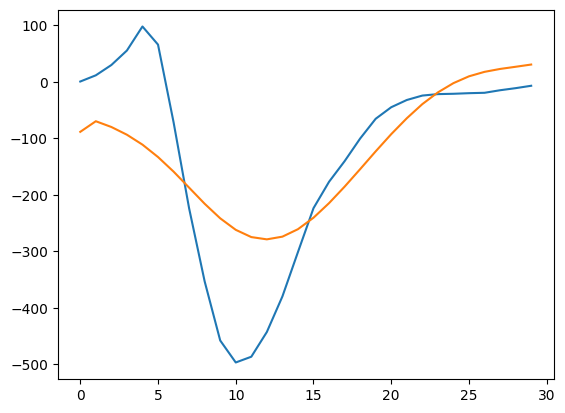

In [64]:
plt.plot(y_test_reshaped[5,:,-1])
plt.plot(traces_sca_reshaped[5,:,-1])

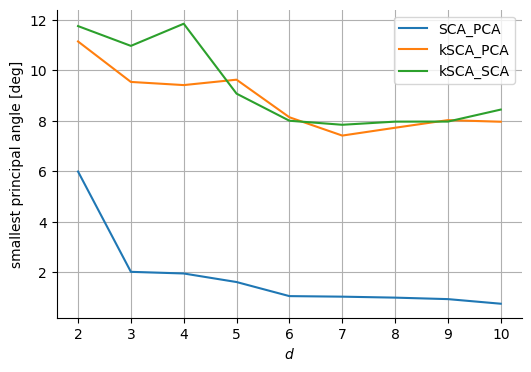

In [7]:
ds = np.arange(2, 11)
data_length = len(ds)
tick_positions = np.linspace(0, data_length - 1, num=9)
tick_labels = ds

fig, ax = plt.subplots(figsize=(6,4))  
ax.plot(ls_principal_angle_SCA_PCA, label='SCA_PCA') 
ax.plot(ls_principal_angle_kSCA_PCA, label='kSCA_PCA')
ax.plot(ls_principal_angle_kSCA_SCA, label='kSCA_SCA')

ax.legend() 
ax.set_xticks(tick_positions)  
ax.set_xticklabels(tick_labels) 
ax.spines[['right', 'top']].set_visible(False)
ax.set_ylabel('smallest principal angle [deg]')
ax.set_xlabel(r"$d$")
ax.grid()

Neural Network Predictions

In [4]:
split = 10 
lag = 5


behaviour = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/behaviour/hand_vel.npy')
y_train = behaviour[split:,:,lag:].swapaxes(1,2).reshape(-1, behaviour.shape[1])
y_test = behaviour[:split,:,lag:].swapaxes(1,2).reshape(-1, behaviour.shape[1])


X = np.load(f"/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/kernel_/neural_psth/projection_10d_gaussian.npy")
X_train = X[split:,:,:-lag].swapaxes(1,2).reshape(-1, X.shape[1])
X_test = X[:split,:,:-lag].swapaxes(1,2).reshape(-1, X.shape[1])


print(get_reg(X_train,y_train,X_test, y_test)[0])

X = np.load(f"/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/kernel_SCA/MC_Maze_3_7_2024/kernel_/neural_psth/projection_10d_linear.npy")
X_train = X[split:,:,:-lag].swapaxes(1,2).reshape(-1, X.shape[1])
X_test = X[:split,:,:-lag].swapaxes(1,2).reshape(-1, X.shape[1])

print(get_reg(X_train,y_train,X_test, y_test)[0])

0.6878838214307408
0.7265474511507006


In [17]:
NN_net=NN(ni=10,no=2,nh_list=[10,5],nonlinearity_out=None).float()                                              
x_input = torch.tensor(X_train).float()                                    
y_input =  torch.tensor(y_train).float()          

num_epochs=10000
lr=1e-1                                                        

loss_fn=nn.MSELoss()
optimizer=optim.Adam(NN_net.parameters(),lr=lr)  

ls_loss = []

for i in range(num_epochs):
  total_loss=0
  y_pred=NN_net(x_input)                                             
  loss=loss_fn(y_pred,y_input)
  total_loss+=loss.item()
  
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ls_loss.append(total_loss) 

  print("epoch:", i, "loss:",total_loss)
  print("__________________________________________________________")

epoch: 0 loss: 80141.03125
__________________________________________________________
epoch: 1 loss: 80109.1171875
__________________________________________________________
epoch: 2 loss: 80052.2421875
__________________________________________________________
epoch: 3 loss: 79948.9609375
__________________________________________________________
epoch: 4 loss: 79788.9453125
__________________________________________________________
epoch: 5 loss: 79554.125
__________________________________________________________
epoch: 6 loss: 79225.6640625
__________________________________________________________
epoch: 7 loss: 78784.859375
__________________________________________________________
epoch: 8 loss: 78213.140625
__________________________________________________________
epoch: 9 loss: 77492.2734375
__________________________________________________________
epoch: 10 loss: 76603.9375
__________________________________________________________
epoch: 11 loss: 75533.265625
_____________

In [22]:
predictions = NN_net(torch.tensor(X_test).float() ).detach().numpy()
y_test_torch =  torch.tensor(y_test).float().detach().numpy()

In [ ]:
predictions = predict(params, X_test)
r2_score(y_test, predictions)

In [27]:
r2_score(y_test_torch, predictions)

0.874992072839863

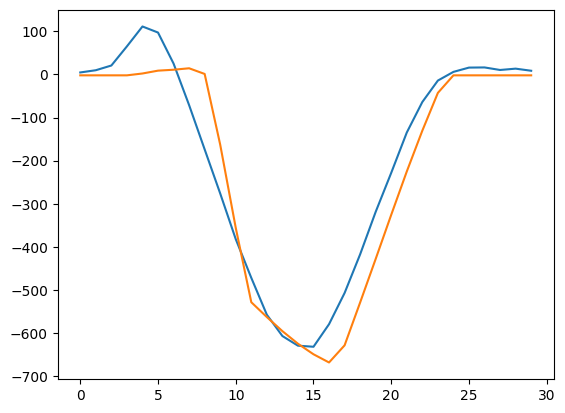

In [26]:
y_test_reshaped = y_test_torch.reshape(split,T-lag,-1)                    #(K[test], T_lag, N)
pred_reshaped = predictions.reshape(split,T-lag,-1)

plt.plot(y_test_reshaped[7,:,0])
plt.plot(pred_reshaped[7,:,0])